In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, RNN
from keras.layers import Dropout

input data of ABBANK

In [2]:
df = pd.read_csv('../input/top-15-organizations-data-of-dhaka-stock-exchange/Data_ABBANK.csv')
df.head()

,date,last_traded_price,high,low,opening_price,closing_price,trade,value_mn,volume,month,day_of_month,day_of_year,day_of_week,difference
0,2012-12-30,33.5,34.0,33.5,33.7,33.7,569,18.9704,562350,12,30,365,6,0.5
1,2012-12-27,33.8,33.9,33.3,33.6,33.6,668,16.0606,477950,12,27,362,3,0.6
2,2012-12-26,33.6,33.7,33.0,33.1,33.5,591,21.0873,629350,12,26,361,2,0.7
3,2012-12-24,33.4,33.6,32.8,33.2,33.3,555,11.5625,348300,12,24,359,0,0.8
4,2012-12-23,33.2,33.9,32.7,33.2,33.2,841,24.4711,739150,12,23,358,6,1.2


In [3]:

df.index  = df['date']
df

,date,last_traded_price,high,low,opening_price,closing_price,trade,value_mn,volume,month,day_of_month,day_of_year,day_of_week,difference
date,,,,,,,,,,,,,,
2012-12-30,2012-12-30,33.5,34.0,33.5,33.7,33.7,569,18.9704,562350,12,30,365,6,0.5
2012-12-27,2012-12-27,33.8,33.9,33.3,33.6,33.6,668,16.0606,477950,12,27,362,3,0.6
2012-12-26,2012-12-26,33.6,33.7,33.0,33.1,33.5,591,21.0873,629350,12,26,361,2,0.7
2012-12-24,2012-12-24,33.4,33.6,32.8,33.2,33.3,555,11.5625,348300,12,24,359,0,0.8
2012-12-23,2012-12-23,33.2,33.9,32.7,33.2,33.2,841,24.4711,739150,12,23,358,6,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-07,2019-01-07,13.3,13.9,13.3,13.8,13.3,285,5.4990,406150,1,7,7,0,0.6
2019-01-06,2019-01-06,13.7,13.9,12.8,13.0,13.7,477,11.4320,846470,1,6,6,6,1.1
2019-01-03,2019-01-03,12.8,13.0,12.2,12.2,12.8,420,16.0610,1280792,1,3,3,3,0.8


Take closing_price for prediction

In [4]:
values = DataFrame(df['closing_price'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.962749  0.920984  0.828895  0.988418
t+1   0.962749  1.000000  0.953735  0.841161  0.953838
t+5   0.920984  0.953735  1.000000  0.856995  0.913608
t+10  0.828895  0.841161  0.856995  1.000000  0.824737
t+30  0.988418  0.953838  0.913608  0.824737  1.000000


Split train and test data

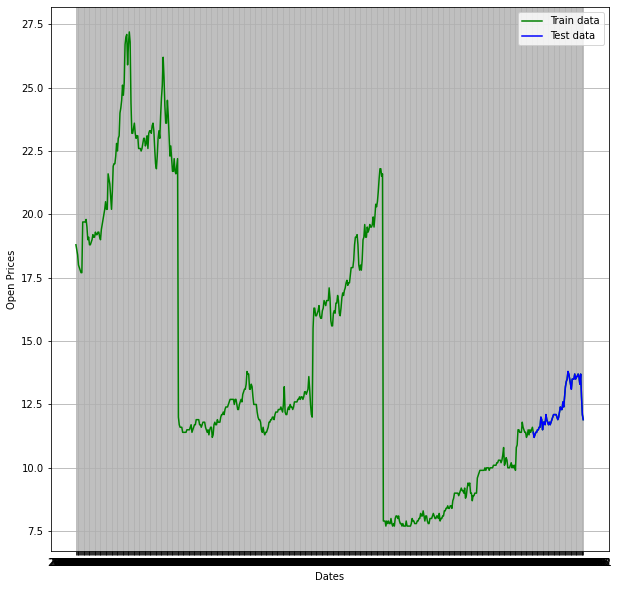

In [5]:
train_data, test_data = df[0:-60], df[-60:]
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(df['closing_price'].tail(600), 'green', label='Train data')
plt.plot(test_data['closing_price'], 'blue', label='Test data')
plt.legend()

Show the closing_price column data

In [6]:
df['closing_price']

date
2012-12-30    33.7
2012-12-27    33.6
2012-12-26    33.5
2012-12-24    33.3
2012-12-23    33.2
              ... 
2019-01-07    13.3
2019-01-06    13.7
2019-01-03    12.8
2019-01-02    12.1
2019-01-01    11.9
Name: closing_price, Length: 1926, dtype: float64

We take 60 days data to test our models

In [7]:
test_data.shape

(60, 14)

In [8]:
train_data.closing_price.tail(30) 

date
2019-05-15    10.0
2019-05-14    10.0
2019-05-13    10.0
2019-05-12    10.1
2019-05-09    10.2
2019-05-08    10.0
2019-05-07    10.1
2019-05-06    10.0
2019-05-05    10.1
2019-05-02     9.9
2019-04-30    10.8
2019-04-29    10.9
2019-04-28    11.5
2019-04-25    11.5
2019-04-24    11.4
2019-04-23    11.4
2019-04-21    11.4
2019-04-18    11.8
2019-04-17    11.6
2019-04-16    11.5
2019-04-15    11.4
2019-04-11    11.4
2019-04-10    11.2
2019-04-09    11.3
2019-04-08    11.5
2019-04-07    11.3
2019-04-04    11.5
2019-04-03    11.4
2019-04-02    11.5
2019-04-01    11.6
Name: closing_price, dtype: float64

MSE: 108.56151194130847
MAE: 10.387637590861853
RMSE: 10.419285577298881


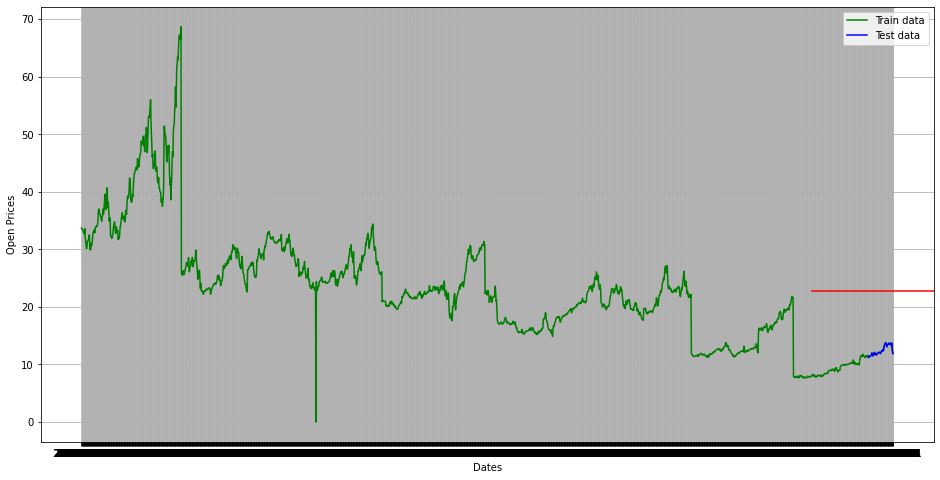

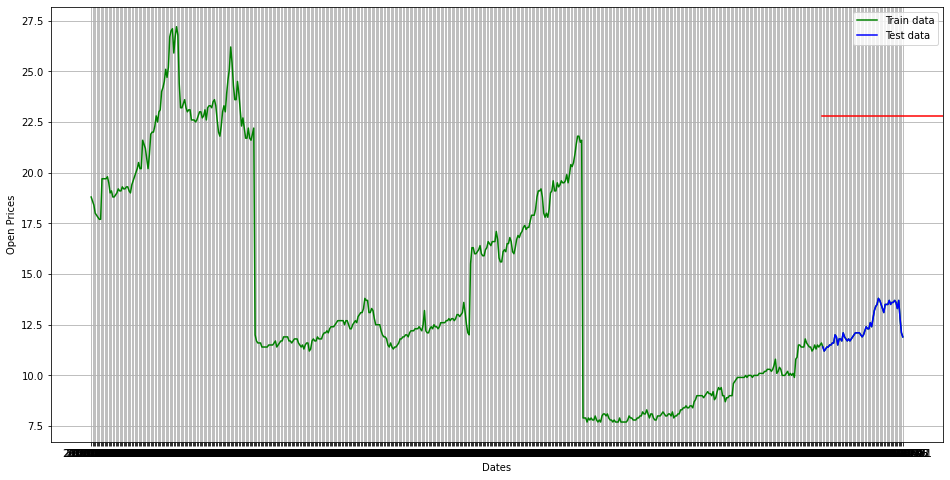

In [9]:
mean_value = df['closing_price'].mean() # calculation of mean price

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(df['closing_price'], 'green', label='Train data')
plt.plot(test_data['closing_price'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(df['closing_price'].tail(600), 'green', label='Train data')
plt.plot(test_data['closing_price'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['closing_price'], np.full(len(test_data), mean_value))))
print('MAE: '+str(mean_absolute_error(test_data['closing_price'], np.full(len(test_data), mean_value))))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['closing_price'], np.full(len(test_data), mean_value)))))

Train data for ARIMA model

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


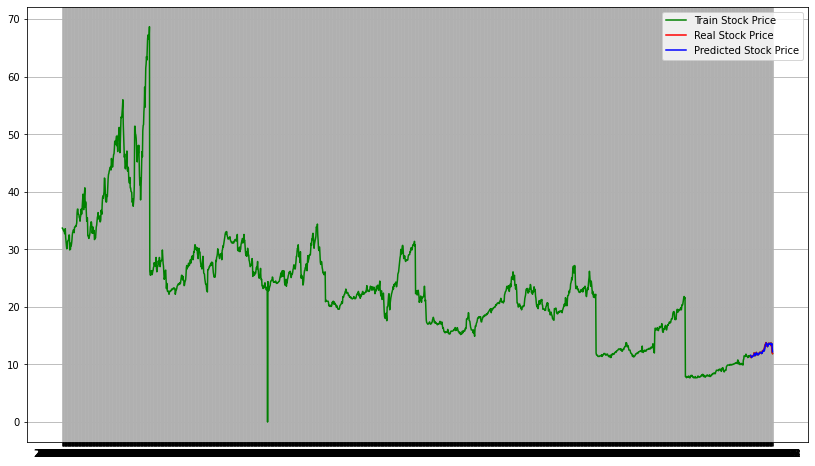

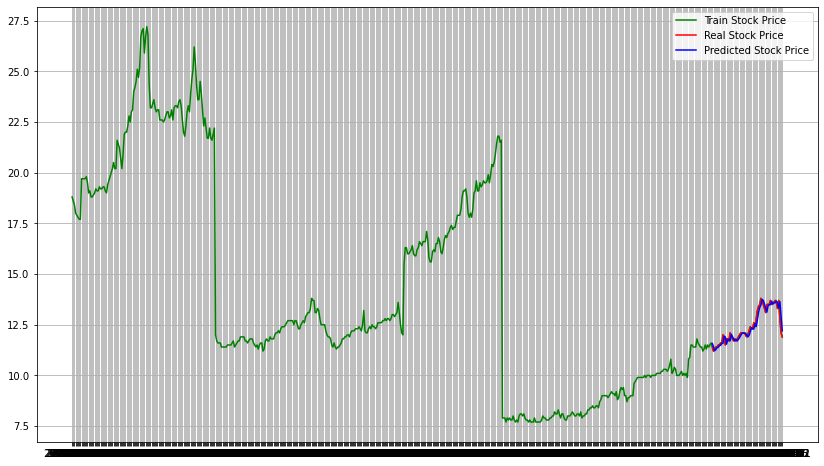

MSE: 0.06150131261786733
MAE: 0.18154679454554123
RMSE: 0.24799458183167497


In [10]:
train_arima = train_data['closing_price']
test_arima = test_data['closing_price']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    
plt.figure(figsize=(14,8))
plt.plot(df.index, df['closing_price'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(df.index[-600:], df['closing_price'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

In [11]:
test_data.reset_index(drop=True, inplace=True)

Predicted result for ARIMA model

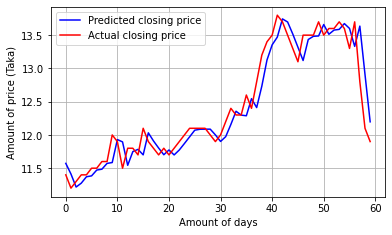

In [12]:
#y_test = df.iloc[int(7200): ,0:1].values
plt.figure(figsize=(6,3.5))
#plt.suptitle('Sine and cosine waves', fontsize=13)
plt.plot(predictions, color='blue', label='Predicted closing price')
plt.plot(test_data['closing_price'], color ='red', label='Actual closing price')
plt.xlabel('Amount of days', fontsize=10)
plt.ylabel('Amount of price (Taka)', fontsize=10)
#plt.xticks(rotation=0,fontsize=12)
#plt.yticks(rotation=0,fontsize=12)
plt.grid(True)
#plt.savefig('ARIMA_Close_Price.jpeg')
plt.legend()
plt.show()

Pre-process data for Prophet model

In [13]:
ph_df_train = train_data.drop(['last_traded_price', 'high', 'low','opening_price',
                               'trade','value_mn','volume','month','day_of_month',
                               'day_of_year','day_of_week','difference'], axis=1)
ph_df_train['date'] = ph_df_train.index
ph_df_train.rename(columns={'closing_price': 'y', 'date': 'ds'}, inplace=True)

prop = Prophet(changepoint_prior_scale=0.1)
prop.fit(ph_df_train)
# Create Future dates
future_prices = prop.make_future_dataframe(periods=73)

# Predict Prices
forecast = prop.predict(future_prices)

Initial log joint probability = -71.8963
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5156.48     0.0338047       2807.78           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5247.28     0.0106081        495.33       2.429      0.2429      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5261.34   0.000814851       202.356           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5276.23    0.00254897       258.674      0.7608      0.7608      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5291.41    0.00468376       230.947           1           1      574   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [14]:
forecast['yhat']

0       55.174192
1       55.220001
2       55.396645
3       55.306056
4       55.358230
          ...    
1933     6.542069
1934     6.367463
1935     6.346219
1936     6.083615
1937     5.992544
Name: yhat, Length: 1938, dtype: float64

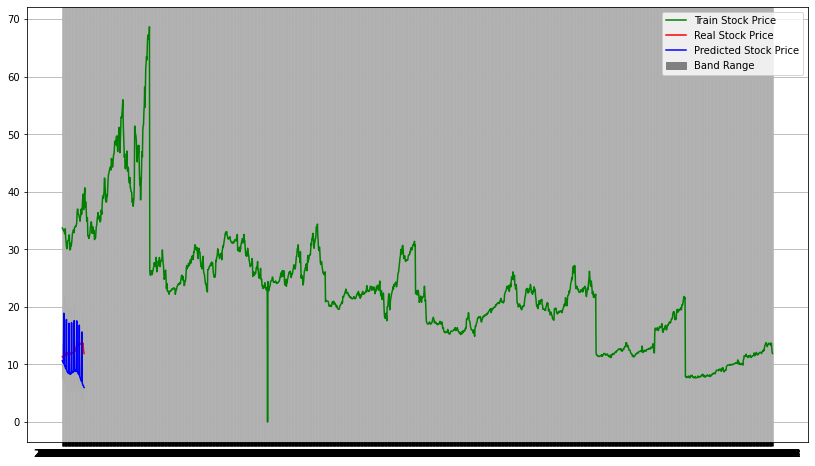

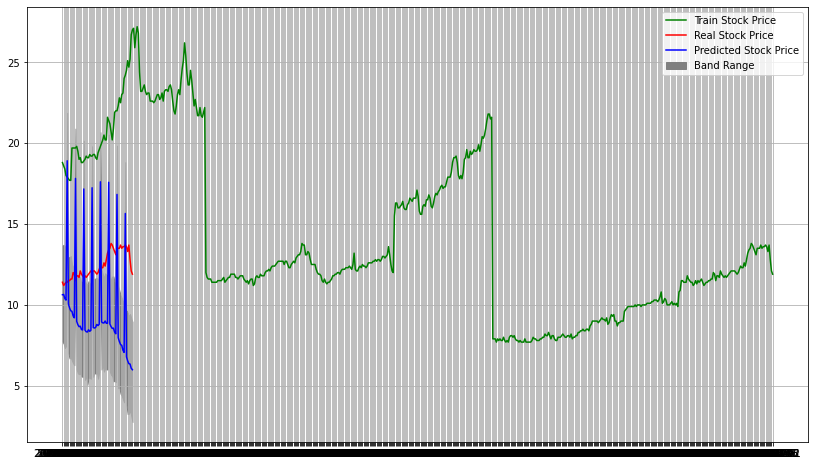

MSE: 19.245057102638786
MAE: 4.044617939592175
RMSE: 4.386918862098863


In [15]:
plt.figure(figsize=(14,8))
plt.plot(df.index, df['closing_price'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['closing_price'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-60:], color = 'blue', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-60:], forecast['yhat_upper'][-60:], color='grey', label="Band Range")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(df.index[-600:], df['closing_price'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['closing_price'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-60:], color = 'blue', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-60:], forecast['yhat_upper'][-60:], color='grey', label="Band Range")
plt.legend()
plt.grid(True)
plt.show()
print('MSE: '+str(mean_squared_error(test_data['closing_price'], forecast['yhat'][-60:])))
print('MAE: '+str(mean_absolute_error(test_data['closing_price'], forecast['yhat'][-60:])))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['closing_price'], forecast['yhat'][-60:]))))

In [16]:
train = train_data.iloc[:, 1:2].values # selecting open prices
# Feature Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 
# Train dataset
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

LSTM model training

In [17]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
#model.add(Dropout(0.2))

model.add(LSTM(units = 50))
#model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 16)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/100
117/117 [==============================] - 5s 10ms/step - loss: 0.0084
Epoch 2/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0020
Epoch 3/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0021
Epoch 4/100
117/117 [==============================] - 2s 14ms/step - loss: 0.0019
Epoch 5/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0018
Epoch 6/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0020
Epoch 7/100
117/117 [==============================] - 1s 11ms/step - loss: 0.0018
Epoch 8/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0019
Epoch 9/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0016
Epoch 10/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0017
Epoch 11/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0017
Epoch 12/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0016
Ep

In [18]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,1:2].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['closing_price'], test_data['closing_price']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

Predicted result for LSTM model

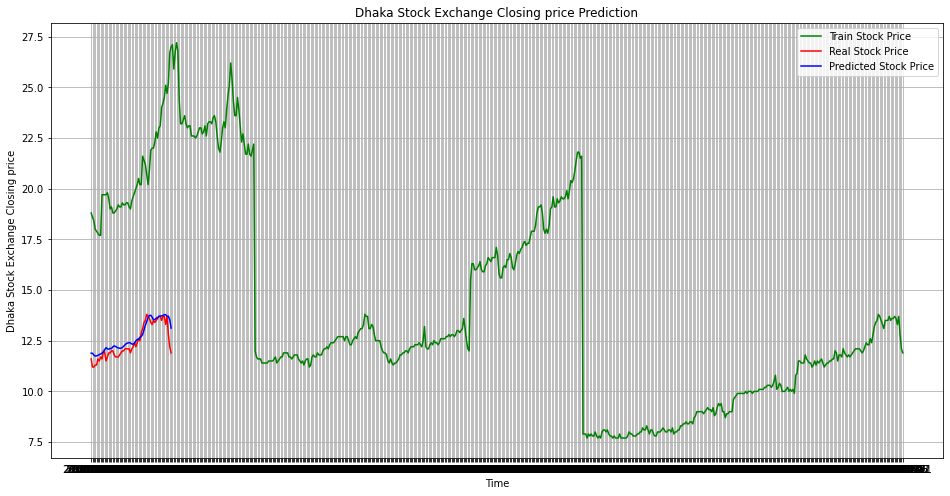

MSE: 0.1551973085853509
MAE: 0.2968792851765952
RMSE: 0.39395089616010637


In [19]:
plt.figure(figsize=(16,8))
plt.plot(df.index[-600:], df['closing_price'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Dhaka Stock Exchange Closing price Prediction')
plt.xlabel('Time')
plt.ylabel('Dhaka Stock Exchange Closing price')
plt.legend()
plt.grid(True)
#plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

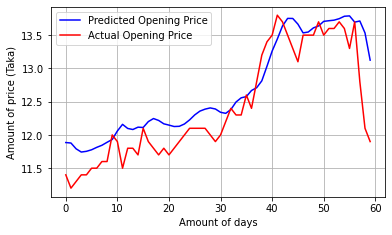

In [20]:
test_data.reset_index(drop=True, inplace=True)
#y_test = df.iloc[int(7200): ,0:1].values
plt.figure(figsize=(6,3.5))
#plt.suptitle('Sine and cosine waves', fontsize=13)
plt.plot(predicted_stock_price, color='blue', label='Predicted Opening Price')
plt.plot(test_data['closing_price'], color ='red', label='Actual Opening Price')
plt.xlabel('Amount of days', fontsize=10)
plt.ylabel('Amount of price (Taka)', fontsize=10)
#plt.xticks(rotation=0,fontsize=12)
#plt.yticks(rotation=0,fontsize=12)
plt.grid(True)
#plt.savefig('LSTM_opening_price.jpeg')
plt.legend()
plt.show()

Training data by GRU model

In [21]:
model = Sequential()

# Adding the first GRU layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) GRU layer ahead in the network.
model.add(GRU(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(GRU(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 16)

Epoch 1/200
117/117 [==============================] - 5s 12ms/step - loss: 0.0083
Epoch 2/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0030
Epoch 3/200
117/117 [==============================] - 2s 13ms/step - loss: 0.0034
Epoch 4/200
117/117 [==============================] - 2s 15ms/step - loss: 0.0027
Epoch 5/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 6/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0024
Epoch 7/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 8/200
117/117 [==============================] - 1s 13ms/step - loss: 0.0022
Epoch 9/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0024
Epoch 10/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0021
Epoch 11/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0021
Epoch 12/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0020
E

In [22]:
# this will be used later while comparing and visualization
real_stock_price_GRU = test_data.iloc[:,1:2].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['closing_price'], test_data['closing_price']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price_GRU = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price_GRU = scaler.inverse_transform(predicted_stock_price_GRU)

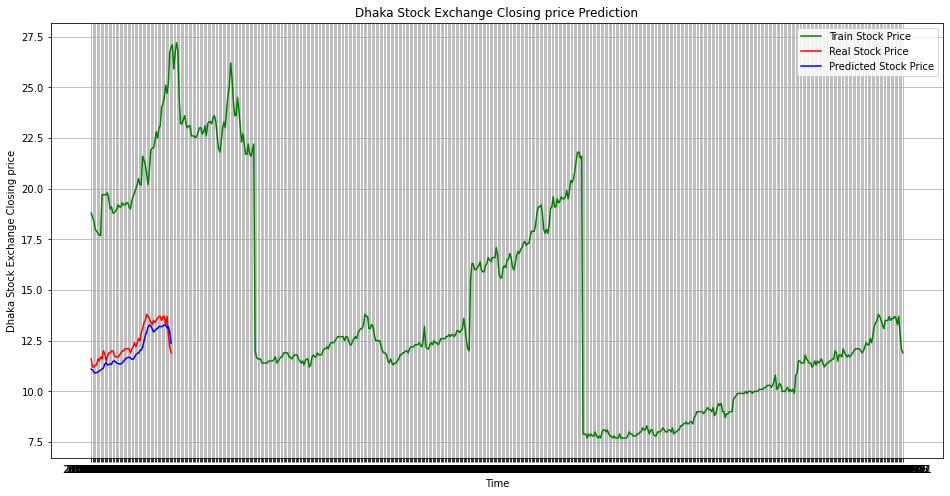

MSE: 0.2743080440206297
MAE: 0.48678358078002915
RMSE: 0.5237442544034537


In [23]:
plt.figure(figsize=(16,8))
plt.plot(df.index[-600:], df['closing_price'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price_GRU, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price_GRU, color = 'blue', label = 'Predicted Stock Price')
plt.title('Dhaka Stock Exchange Closing price Prediction')
plt.xlabel('Time')
plt.ylabel('Dhaka Stock Exchange Closing price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price_GRU, predicted_stock_price_GRU)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price_GRU, predicted_stock_price_GRU)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price_GRU, predicted_stock_price_GRU))
print('RMSE: '+str(rmse))

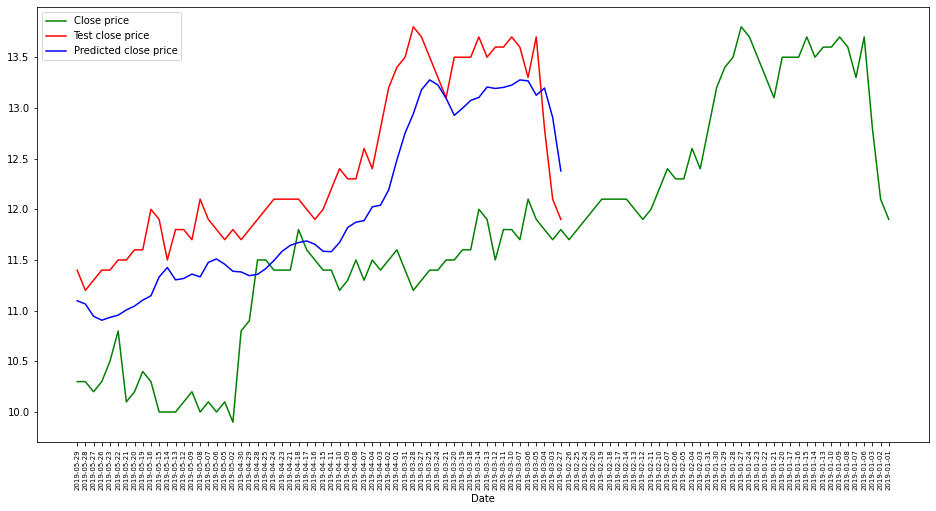

In [24]:
plt.figure(figsize=(16,8))
#print('Lag: %s' % model_fit.k_ar)
plt.plot(df.index[-100:], df['closing_price'].tail(100), color='green', label='Close price')
plt.plot(test_data.index, test_data['closing_price'], color='red', label='Test close price')
plt.plot(test_data.index, predicted_stock_price_GRU, color='blue', label='Predicted close price')
plt.xlabel('Date', fontsize=10)
plt.xticks(rotation=90,fontsize=7)
#plt.grid(True)
plt.legend()